In [3]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion XL 1.0 (Dreambooth LoRA Finetuning)

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_pytorch_sd_xl_finetuning_dreambooth_lora.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_sd_xl_finetuning_dreambooth_lora.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## LoRA Finetune with Dreambooth

In [15]:
!pip install tensorflow
!pip install huggingface_hub
!pip install google-cloud-storage

In [9]:
import socket
import re

UNIQUE_PREFIX = socket.gethostname()
UNIQUE_PREFIX = re.sub('[^A-Za-z0-9]+', '', UNIQUE_PREFIX)[:-6]

# Cloud project id.
PROJECT_IDS = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_IDS[0]  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output.
# Remove prefix gs://, e.g. foo_bucket.
GCS_BUCKET_LOCATION = "asia-southeast1"
REGION = 'asia-southeast1'

PROJECT_ID_PREFIX = PROJECT_ID[:-6]
GCS_BUCKET_URI = f"gs://hk-{PROJECT_ID_PREFIX}{UNIQUE_PREFIX}-{REGION}"

# print variables for verification
print(f"Project ID: {PROJECT_ID}")
print(f"GCS Bucket URI: {GCS_BUCKET_URI}")

! gcloud storage buckets create {GCS_BUCKET_URI} --project={PROJECT_ID} --location={GCS_BUCKET_LOCATION}
! pip install -q gdown

Project ID: prusandbx-nprd-uat-u9pahg
GCS Bucket URI: gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1


In [10]:
REGION

'asia-southeast1'

In [11]:
# @title Setup Google Cloud project

# @markdown 1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

# @markdown 2. **[Optional]** [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs. Set the BUCKET_URI for the experiment environment. The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the same region as where the notebook was launched. Note that a multi-region bucket (eg. "us") is not considered a match for a single region covered by the multi-region range (eg. "us-central1"). If not set, a unique GCS bucket will be created instead.

BUCKET_URI = GCS_BUCKET_URI # @param {type:"string"}

# @markdown 3. **[Optional]** Set region. If not set, the region will be set automatically according to Colab Enterprise environment.

REGION = REGION  # @param {type:"string"}

# @markdown 4. If you want to run predictions with A100 80GB or H100 GPUs, we recommend using the regions listed below. **NOTE:** Make sure you have associated quota in selected regions. Click the links to see your current quota for each GPU type: [Nvidia A100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_a100_80gb_gpus), [Nvidia H100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_h100_gpus).

# @markdown > | Machine Type | Accelerator Type | Recommended Regions |
# @markdown | ----------- | ----------- | ----------- |
# @markdown | a2-ultragpu-1g | 1 NVIDIA_A100_80GB | us-central1, us-east4, europe-west4, asia-southeast1, us-east4 |
# @markdown | a3-highgpu-2g | 2 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-4g | 4 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-8g | 8 NVIDIA_H100_80GB | us-central1, us-east5, europe-west4, us-west1, asia-southeast1 |

import importlib
import math
import os
import uuid
from datetime import datetime

from google.cloud import aiplatform

! git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

common_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.common_util"
)

# Get the default cloud project id.
PROJECT_ID = PROJECT_ID #os.environ["GOOGLE_CLOUD_PROJECT"]

# Enable the Vertex AI API and Compute Engine API, if not already.
print("Enabling Vertex AI and Compute Engine API.")
! gcloud services enable aiplatform.googleapis.com compute.googleapis.com

# Cloud Storage bucket for storing the experiment artifacts.
# If a custom gcs bucket uri is not provided, a unique GCS bucket will be
# created for the purpose of this notebook.
now = datetime.now().strftime("%Y%m%d%-H%M%S")
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])

assert BUCKET_URI.startswith("gs://"), "BUCKET_URI must start with `gs://`."
if BUCKET_URI is None or BUCKET_URI.strip() == "" or BUCKET_URI == "gs://":
    # Create a unique GCS bucket for this notebook, if not specified by the user
    BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}-{str(uuid.uuid4())[:4]}"
    BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
    ! gsutil mb -l {REGION} {BUCKET_URI}
else:
    shell_output = ! gsutil ls -Lb {BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if bucket_region != REGION:
        raise ValueError(
            "Bucket region %s is different from notebook region %s"
            % (bucket_region, REGION)
        )

# Cloud Storage bucket for storing the experiment artifacts.
# A unique GCS bucket will be created for the purpose of this notebook. If you
# prefer using your own GCS bucket, change the value yourself below.
print(f"Using this GCS Bucket: {BUCKET_URI}")

# Set up the default SERVICE_ACCOUNT.
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
SERVICE_ACCOUNT_CC = (
    f"service-{project_number}@gcp-sa-aiplatform-cc.iam.gserviceaccount.com"
)

print("Using this default Service Account:", SERVICE_ACCOUNT)

# Provision permissions to the two SERVICE_ACCOUNTs with the GCS bucket
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT_CC}:roles/storage.admin $BUCKET_NAME

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

fatal: destination path 'vertex-ai-samples' already exists and is not an empty directory.
Enabling Vertex AI and Compute Engine API.
Operation "operations/acat.p2-190852132224-434588b8-35d4-40e7-a3ad-8ca0cbc17ee5" finished successfully.
Using this GCS Bucket: gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1
Using this default Service Account: 190852132224-compute@developer.gserviceaccount.com


In [19]:
from google.cloud import storage
import glob

In [ ]:
# @title Start Dreambooth LoRA finetune

# @markdown This section uses [Dreambooth LoRA](https://dreambooth.github.io/) to finetune
# @markdown the [stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) model
# @markdown with [5 dog images](https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ) to
# @markdown personalize the text-to-image model.

# @markdown In this example, we will default to use the images in [diffusers/dog-example](https://huggingface.co/datasets/diffusers/dog-example)
# @markdown as the training dataset. If you need to train based on your own images, choose the `IMAGE_SOURCE` option as
# @markdown "Use my own images in a GCS bucket" and provide the GCS path to your images below.

# @markdown It finetunes both text encoder and unet of the stable diffusion model up to 200 steps.
# @markdown The whole finetuning job takes 20 minutes to finish using 1 L4 GPU.

# @markdown The full model will be saved after the finetuning job finishes and it can be loaded
# @markdown by the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img)
# @markdown to run inference.

# @markdown Click "Show code" to modify the code to change GPU type, count, and other training parameters.

IMAGE_SOURCE = "Default image examples from HuggingFace"  # @param ["Default image examples from HuggingFace", "Use my own images in a GCS bucket"] {isTemplate:true}

# The pre-built training docker images. They contain training scripts and models.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-train:20240318_0936_RC00"

# Input and output path.
instance_dir = os.path.join(BUCKET_URI, "dreambooth-lora-sdxl/images")
class_dir = os.path.join(BUCKET_URI, "dreambooth-lora-sdxl/image_class")
output_dir = os.path.join(BUCKET_URI, "dreambooth-lora-sdxl/output")

from huggingface_hub import snapshot_download


def get_bucket_and_blob_name(filepath):
    # The gcs path is of the form gs://<bucket-name>/<blob-name>
    gs_suffix = filepath.split("gs://", 1)[1]
    return tuple(gs_suffix.split("/", 1))


def download_gcs_dir_to_local(gcs_dir_path, local_dir_path):
    """Downloads files in a GCS directory to a local directory."""
    assert gcs_dir_path.startswith("gs://"), "gcs_dir_path must start with `gs://`."
    bucket_name = gcs_dir_path.split("/")[2]
    prefix = gcs_dir_path[len("gs://" + bucket_name) :].strip("/") + "/"
    client = storage.Client()
    blobs = client.list_blobs(bucket_name, prefix=prefix)
    for blob in blobs:
        if blob.name[-1] == "/":
            continue
        file_path = blob.name[len(prefix) :].strip("/")
        local_file_path = os.path.join(local_dir_path, file_path)
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        print(f"Downloading {file_path} to {local_file_path}")
        blob.download_to_filename(local_file_path)


def upload_local_dir_to_gcs(local_dir_path, gcs_dir_path):
    """Uploads files in a local directory to a GCS directory."""
    client = storage.Client()
    bucket_name = gcs_dir_path.split("/")[2]
    bucket = client.get_bucket(bucket_name)
    for local_file in glob.glob(local_dir_path + "/**"):
        if not os.path.isfile(local_file):
            continue
        filename = local_file[1 + len(local_dir_path) :]
        gcs_file_path = os.path.join(gcs_dir_path, filename)
        _, blob_name = get_bucket_and_blob_name(gcs_file_path)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(local_file)
        print("Copied {} to {}.".format(local_file, gcs_file_path))


# Worker pool spec.
machine_type = "g2-standard-8"
num_nodes = 1
gpu_type = "NVIDIA_L4"
num_gpus = 1

common_util.check_quota(
    project_id=PROJECT_ID,
    region=REGION,
    accelerator_type=gpu_type,
    accelerator_count=num_gpus,
    is_for_training=True,
)

local_dir = "./campaign"
if IMAGE_SOURCE == "Default image examples from HuggingFace":
    snapshot_download(
        "diffusers/dog-example",
        local_dir=local_dir,
        repo_type="dataset",
        ignore_patterns=".gitattributes",
        token="False",
    )
    print("Finished downloading training images from huggingface.")
else:
    # @markdown **[Optional]** If using own images, provide the GCS path to the images.
    # @markdown Make sure you have permission to access the bucket.
    source_image_gcs_dir = "gs://"  # @param {type:"string"}
    assert source_image_gcs_dir.startswith(
        "gs://"
    ), "source_image_gcs_dir must start with `gs://`."
    print(
        f"Now downloading the images from the source gcs directory: {source_image_gcs_dir}"
    )
    download_gcs_dir_to_local(source_image_gcs_dir, local_dir)


# Upload data to Cloud Storage bucket.
print(f"Now uploading the images to the bucket: {instance_dir}")
upload_local_dir_to_gcs(local_dir, instance_dir)
upload_local_dir_to_gcs(local_dir, class_dir)

# The pre-trained model to be loaded.
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# @markdown Default to 200. Increase it to 400 or 800 if you want to achieve a higher model quality.
train_steps = 200  # @param {type: "number"}

# Setup training job.

job_name = common_util.create_job_name("dreambooth-lora-sdxl")
job = aiplatform.CustomContainerTrainingJob(
    display_name=job_name,
    container_uri=TRAIN_DOCKER_URI,
)

BUCKET_GCS_FUSE = BUCKET_URI.replace("gs://", "/gcs/")
instance_dir_fuse = instance_dir.replace("gs://", "/gcs/")
class_dir_fuse = class_dir.replace("gs://", "/gcs/")
output_dir_fuse = output_dir.replace("gs://", "/gcs/")


concept_prompt = "A picture of a sks dog"  # @param {type:"string"}
model = job.run(
    args=[
        "--task=text-to-image-dreambooth-lora-sdxl",
        f"--pretrained_model_name_or_path={model_id}",
        f"--instance_data_dir={instance_dir_fuse}",
        f"--class_data_dir={class_dir_fuse}",
        f"--output_dir={output_dir_fuse}",
        f"--instance_prompt={concept_prompt}",
        "--pretrained_vae_model_name_or_path=madebyollin/sdxl-vae-fp16-fix",
        "--mixed_precision=fp16",
        "--resolution=1024",
        "--train_batch_size=1",
        "--gradient_accumulation_steps=4",
        "--gradient_checkpointing",
        "--learning_rate=1e-4",
        "--lr_scheduler=linear",
        "--lr_warmup_steps=0 ",
        "--use_8bit_adam",
        f"--max_train_steps={int(train_steps)}",
        f"--checkpointing_steps={int(train_steps // 2)}",
        "--seed=0",
    ],
    replica_count=num_nodes,
    machine_type=machine_type,
    accelerator_type=gpu_type,
    accelerator_count=num_gpus,
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Finished downloading training images from huggingface.
Now uploading the images to the bucket: gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/images
Copied ./campaign/post-ADpoJH9WSuRXsnPY3Rq8.png to gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/images/post-ADpoJH9WSuRXsnPY3Rq8.png.
Copied ./campaign/post-JA7NkB38IEcRnct0f4Aa (1).png to gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/images/post-JA7NkB38IEcRnct0f4Aa (1).png.
Copied ./campaign/alvan-nee-9M0tSjb-cpA-unsplash.jpeg to gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/images/alvan-nee-9M0tSjb-cpA-unsplash.jpeg.
Copied ./campaign/post-rW8t6PMl4rPSjdwRJNWz.png to gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/images/post-rW8t6PMl4rPSjdwRJNWz.png.
Copied ./campaign/alvan-nee-bQaAJCbNq3g-unsplash.jpeg to gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-l

In [29]:
# @title Deploy the SD model to Vertex for online predictions

# @markdown This section uploads the model to Model Registry and deploys it on the Endpoint. It takes ~15 minutes to finish.
# @markdown Click "Show Code" to see more details.

# @markdown `text-to-image` lets you send text prompts to the endpoint to generate images.

# The pre-built serving docker images. They contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/deeplearning-platform-release/vertex-model-garden/pytorch-inference.cu125.0-1.ubuntu2204.py310"

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
lora_id = os.path.join(BUCKET_URI, "dreambooth-lora-sdxl/output")

print("LoRA weights are saved in:", lora_id)

accelerator_type = "NVIDIA_L4"  # @param ["NVIDIA_L4", "NVIDIA_A100_80GB"]
machine_type_map = {
    "NVIDIA_L4": "g2-standard-96",
    "NVIDIA_A100_80GB": "a2-ultragpu-1g",
}


def deploy_model(
    model_id,
    lora_id,
    task,
    accelerator_type,
    machine_type,
    accelerator_count=8,
):
    """Create a Vertex AI Endpoint and deploy the specified model to the endpoint."""
    common_util.check_quota(
        project_id=PROJECT_ID,
        region=REGION,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        is_for_training=False,
    )

    model_name = model_id
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "LORA_ID": lora_id,
        "TASK": task,
        "DEPLOY_SOURCE": "notebook",
    }
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predict",
        serving_container_health_route="/health",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        # accelerator_count=1,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    print("To load this existing endpoint from a different session:")
    print(
        f'endpoint = aiplatform.Endpoint("projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint.name}")'
    )
    return model, endpoint


# Set the model_id to "stabilityai/stable-diffusion-xl-base-1.0" to load the OSS pre-trained model.
model, endpoint = deploy_model(
    model_id=model_id,
    lora_id=lora_id,
    task="text-to-image-sdxl",
    accelerator_type=accelerator_type,
    machine_type=machine_type_map[accelerator_type],
)
print("endpoint_name:", endpoint.name)

# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint.name` allows us to get the
#   endpoint name of the endpoint `endpoint` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# endpoint = aiplatform.Endpoint(aip_endpoint_name)

LoRA weights are saved in: gs://hp-bk-prusandbx-nprd-uat--aigpu1005f-asia-southeast1/dreambooth-lora-sdxl/output
Creating Endpoint
Create Endpoint backing LRO: projects/190852132224/locations/asia-southeast1/endpoints/1622514124736954368/operations/4189705000559050752
Endpoint created. Resource name: projects/190852132224/locations/asia-southeast1/endpoints/1622514124736954368
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/190852132224/locations/asia-southeast1/endpoints/1622514124736954368')
Creating Model
Create Model backing LRO: projects/190852132224/locations/asia-southeast1/models/6644630241627078656/operations/2739545920545751040
Model created. Resource name: projects/190852132224/locations/asia-southeast1/models/6644630241627078656@1
To use this Model in another session:
model = aiplatform.Model('projects/190852132224/locations/asia-southeast1/models/6644630241627078656@1')
Deploying model to Endpoint : projects/190852132224/locations/asia-sou

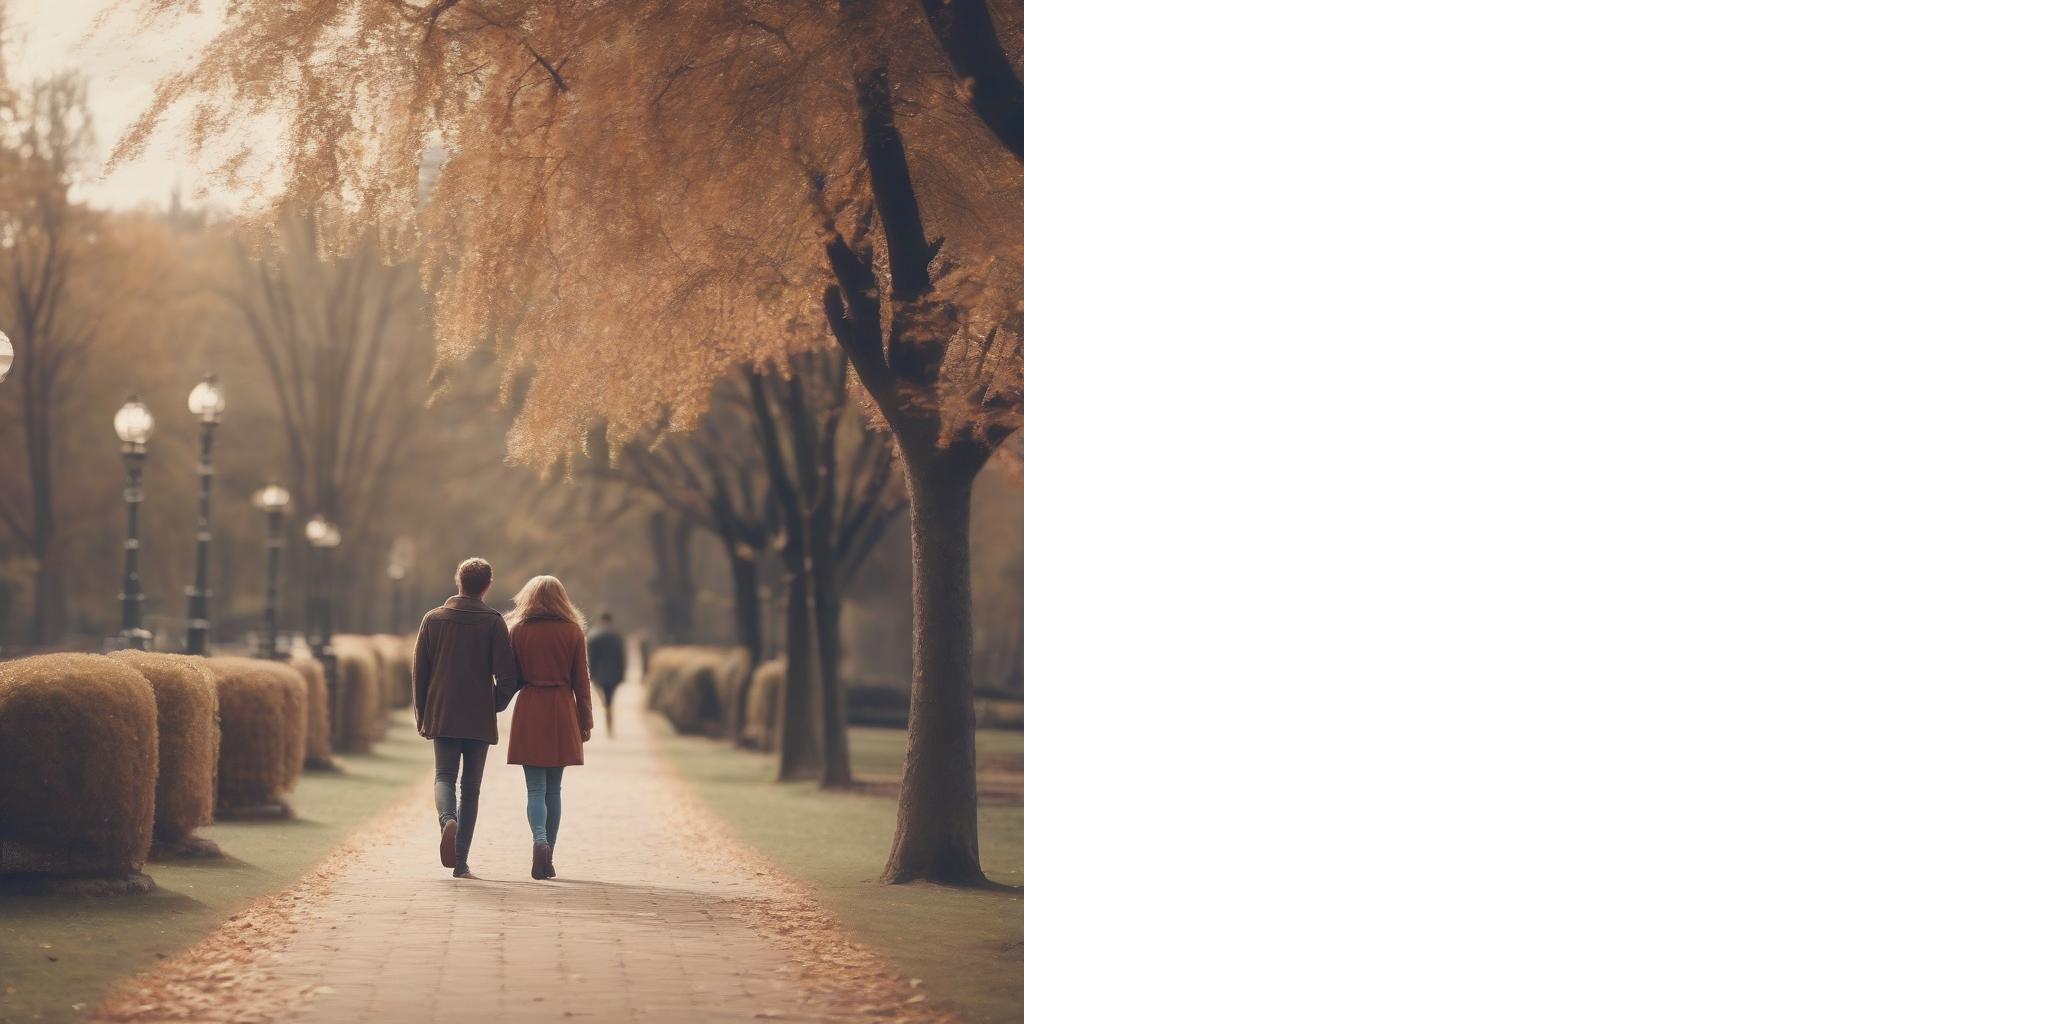

In [30]:
# @title Predict (text-to-image)

# @markdown This section is only for sending predictions to an endpoint with the task `text-to-image`.

# @markdown Once deployment succeeds, you can generate images by sending text prompts to the endpoint.

# @markdown You can also batch send prompts by separating them with a comma. Be sure to include
# @markdown the `concept_prompt` of your instance in the prompt.
# @markdown You may adjust the parameters below to achieve best image quality.

comma_separated_prompt_list = "A picture of couple walking in park far from behind"  # @param {type: "string"}
prompt_list = [x.strip() for x in comma_separated_prompt_list.split(",")]
negative_prompt = ""  # @param {type: "string"}
height = 1024  # @param {type:"number"}
width = 1024  # @param {type:"number"}
num_inference_steps = 25  # @param {type:"number"}
guidance_scale = 7.5  # @param {type:"number"}

instances = [{"text": comma_separated_prompt_list}]
parameters = {
    "negative_prompt": negative_prompt,
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
    "guidance_scale": guidance_scale,
}
response = endpoint.predict(instances=instances, parameters=parameters)

images = [
    common_util.base64_to_image(prediction.get("output"))
    for prediction in response.predictions
]
common_util.image_grid(images, rows=math.ceil(len(images) ** 0.5))

### Change to your own Prompt --- example below

In [ ]:
comma_separated_prompt_list = "A picture of couple walking in park far from behind"  # @param {type: "string"}
prompt_list = [x.strip() for x in comma_separated_prompt_list.split(",")]
negative_prompt = ""  # @param {type: "string"}
height = 1024  # @param {type:"number"}
width = 1024  # @param {type:"number"}
num_inference_steps = 25  # @param {type:"number"}
guidance_scale = 7.5  # @param {type:"number"}

instances = [{"text": comma_separated_prompt_list}]
parameters = {
    "negative_prompt": negative_prompt,
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
    "guidance_scale": guidance_scale,
}
response = endpoint.predict(instances=instances, parameters=parameters)

images = [
    common_util.base64_to_image(prediction.get("output"))
    for prediction in response.predictions
]
common_util.image_grid(images, rows=math.ceil(len(images) ** 0.5))

In [27]:
# @title Clean up resources
# @markdown  Delete the experiment models and endpoints to recycle the resources
# @markdown  and avoid unnecessary continuous charges that may incur.

# Undeploy model and delete endpoint.
# endpoint.delete(force=True)

# Delete models.
# model.delete()

# delete_bucket = False  # @param {type:"boolean"}
# if delete_bucket:
#     ! gsutil -m rm -r $BUCKET_NAME